# Classification supervisée d'images via CNN Transfer Learning

L'apprentissage par transfert est le phénomène par lequel un apprentissage nouveau est facilité grâce aux apprentissages antérieurs partageant des similitudes.

Le transfer learning consiste à ré-utiliser la partie convolutionnelle d'un modèle pré-entrainé sur une autre tâche de classification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_rand_score,auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import plot_keras_history
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
import datetime

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

### Fonctions

In [2]:
#fonction qui crée le modele de classification

def create_model_fct() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        #Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1), #la couche de redimensionnement qui normalise les valeurs de pixel dans la plage [-1,1]
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'), #couche de correction ReLu (Rectified Linear Unit)
                Dropout(0.5),
                Dense(7, activation='softmax') #fonction d'activation softmax car classification multi-classe
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", # calcul l'erreur de classification : entropie croisée
                  optimizer='adam',
                  metrics=["accuracy"])

    print(model.summary())
    
    return model

### Creation d'un dataframe de score

In [3]:
# On crée un dataframe pour ajouter les scores au fur et à mesure
scores = pd.DataFrame(columns = ['Modèle', 'Validation Accuracy', 'Test Accuracy', 'Validation Loss','Test Loss',"Temps nécessaire pour l'entrainement du modèle" ])

### Creation datasets d'entrainement, de test et de validation

In [4]:
batch_size = 32
# On utilise les images qui sont classés dans des dossiers des differents catégories de produits
path = './Flipkart/Images/df_train'
path_test = './Flipkart/Images/df_test'

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                          labels='inferred', 
                                                          label_mode='categorical',
                                                          class_names=None, 
                                                          batch_size=batch_size,
                                                          image_size=(224, 224),
                                                          shuffle=True, 
                                                          seed=42,
                                                          validation_split=validation_split, 
                                                          subset=data_type)
    return dataset

In [5]:
# on crée les datasets d'entrainement, de validation et de test
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


### Creation du modèle

In [6]:
# Création du modèle
model1 = create_model_fct()

# Création du callback
model1_save_path = "./model5_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

### Entrainement du modèle

In [7]:
start = time.time()
#on stocke l'historique du modèle de l'apprentissage dans une variable

history1 = model1.fit(dataset_train,
                      validation_data=dataset_val,
                      #batch_size=batch_size, #ignored because the date is a generator
                      epochs=20, 
                      callbacks=callbacks_list, 
                      verbose=1)

end = time.time()
elapsed1 = end - start

print(f'Temps d\'exécution : {elapsed1:.2}ms')

Epoch 1/20


2023-10-09 12:31:31.659178: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - ETA: 0s - loss: 1.9782 - accuracy: 0.2337
Epoch 1: val_loss improved from inf to 1.49361, saving model to ./model5_best_weights.h5
18/18 [==============================] - 47s 2s/step - loss: 1.9782 - accuracy: 0.2337 - val_loss: 1.4936 - val_accuracy: 0.5902
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 1.5105 - accuracy: 0.4710
Epoch 2: val_loss improved from 1.49361 to 1.23100, saving model to ./model5_best_weights.h5
18/18 [==============================] - 45s 2s/step - loss: 1.5105 - accuracy: 0.4710 - val_loss: 1.2310 - val_accuracy: 0.6557
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 1.2823 - accuracy: 0.6033
Epoch 3: val_loss improved from 1.23100 to 1.03779, saving model to ./model5_best_weights.h5
18/18 [==============================] - 45s 2s/step - loss: 1.2823 - accuracy: 0.6033 - val_loss: 1.0378 - val_accuracy: 0.7486
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss:

In [8]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 45s 2s/step - loss: 0.4030 - accuracy: 0.8913
Training Accuracy   : 0.8913

6/6 [==============================] - 13s 2s/step - loss: 0.6482 - accuracy: 0.7814
Validation Accuracy :  0.7814


In [9]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path)

loss_val_1, accuracy_val_1 = model1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_1))

loss_test_1, accuracy_test_1 = model1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_1))

Validation Accuracy :  0.8033
Test Accuracy       :  0.7778


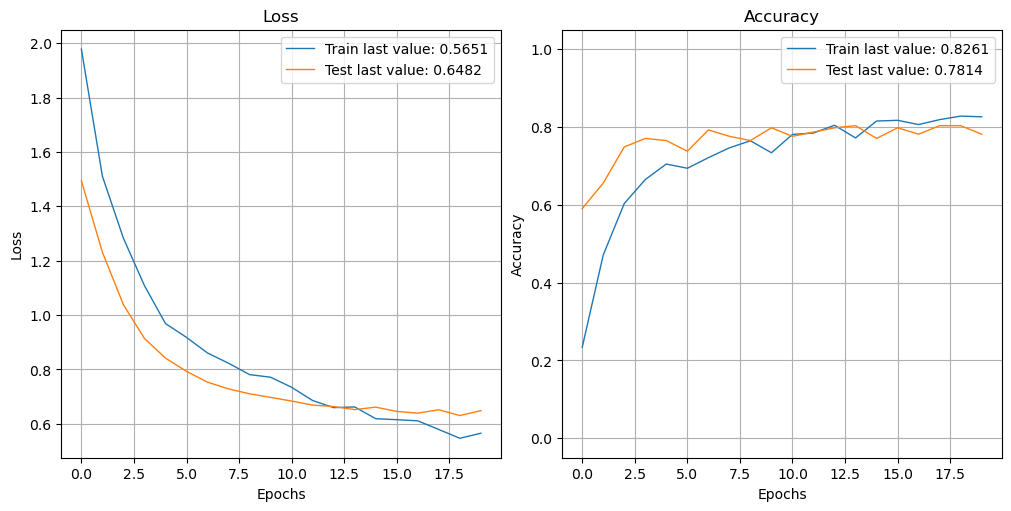

In [10]:
#on trace les historiques pour la précision et les pertes 

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [11]:
time1 = time.strftime("%H:%M:%S", time.gmtime(elapsed1))

In [12]:
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Essai 1',
                                          'Validation Accuracy': accuracy_val_1,
                                          'Test Accuracy':accuracy_test_1,
                                          'Validation Loss':loss_val_1,
                                          'Test Loss':loss_test_1,
                                         "Temps nécessaire pour l'entrainement du modèle":time1
                                         }, index = [0])]).reset_index(drop=True)


In [13]:
scores

,Modèle,Validation Accuracy,Test Accuracy,Validation Loss,Test Loss,Temps nécessaire pour l'entrainement du modèle
0,Essai 1,0.803279,0.777778,0.630203,0.689549,00:30:28


## Création des features des images

In [14]:
class_names = dataset_train.class_names
print(class_names)

['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


In [15]:
#on crée un dataframe des categories de produit
label_df = pd.DataFrame(class_names, columns = ["category"])

# on encode les catégories 
label_df['label'] = LabelEncoder().fit_transform(label_df.category)
 
# on crée un cat-2-index dictionary
dict_df = label_df[['label','category']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)
 
index_to_cat = dict_df.to_dict()['category']
index_to_cat

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

In [16]:
# On crée des listes de labels et predictions
predictions = np.array([])
labels =  np.array([])
for x, y in dataset_test:
    predictions = np.concatenate([predictions, np.argmax(model1.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 2s 2s/step


In [17]:
confusionMatrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
confusionMatrix

array([[19,  2,  0,  4,  6,  1,  1],
       [ 2, 33,  4,  3,  1,  1,  1],
       [ 0,  3, 36,  3,  0,  1,  0],
       [ 1,  1,  0, 42,  2,  3,  2],
       [10,  1,  2,  2, 32,  1,  0],
       [ 3,  2,  2,  1,  0, 43,  0],
       [ 0,  1,  3,  0,  0,  0, 40]], dtype=int32)

<Axes: >

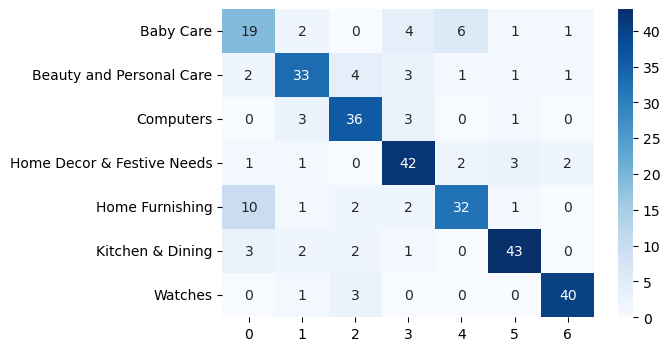

In [18]:
# on crée une liste des catégories
df_cm = pd.DataFrame(confusionMatrix, index = [label for label in class_names],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [19]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56        33
         1.0       0.77      0.73      0.75        45
         2.0       0.77      0.84      0.80        43
         3.0       0.76      0.82      0.79        51
         4.0       0.78      0.67      0.72        48
         5.0       0.86      0.84      0.85        51
         6.0       0.91      0.91      0.91        44

    accuracy                           0.78       315
   macro avg       0.77      0.77      0.77       315
weighted avg       0.78      0.78      0.78       315



In [20]:
ARI = np.round(adjusted_rand_score(labels,predictions),4)
ARI

0.5727

## Essai 2 : on fait varier le batch size

### Creation datasets d'entrainement, de test et de validation

In [21]:
batch_size = 64
# On utilise les images qui sont classés dans des dossiers des differents catégories de produits
path = './Flipkart/Images/df_train'
path_test = './Flipkart/Images/df_test'

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                          labels='inferred', 
                                                          label_mode='categorical',
                                                          class_names=None, 
                                                          batch_size=batch_size,
                                                          image_size=(224, 224),
                                                          shuffle=True, 
                                                          seed=42,
                                                          validation_split=validation_split, 
                                                          subset=data_type)
    return dataset

In [22]:
# on crée les datasets d'entrainement, de validation et de test
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


### Creation du modèle

In [23]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model6_best_weights.h5"

checkpoint = ModelCheckpoint(model2_save_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

### Entrainement du modèle

In [24]:
start = time.time()
#on stocke l'historique du modèle de l'apprentissage dans une variable
history2 = model2.fit(dataset_train,
                      validation_data=dataset_val,
                      #batch_size=batch_size, #ignored because the date is a generator
                      epochs=20, 
                      callbacks=callbacks_list, 
                      verbose=1)
end = time.time()
elapsed2 = end - start

print(f'Temps d\'exécution : {elapsed2:.2}ms')

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 2.0053 - accuracy: 0.1830
Epoch 1: val_loss improved from inf to 1.65723, saving model to ./model6_best_weights.h5
9/9 [==============================] - 47s 5s/step - loss: 2.0053 - accuracy: 0.1830 - val_loss: 1.6572 - val_accuracy: 0.4973
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 1.6759 - accuracy: 0.3859
Epoch 2: val_loss improved from 1.65723 to 1.36192, saving model to ./model6_best_weights.h5
9/9 [==============================] - 46s 5s/step - loss: 1.6759 - accuracy: 0.3859 - val_loss: 1.3619 - val_accuracy: 0.6776
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.5435
Epoch 3: val_loss improved from 1.36192 to 1.17110, saving model to ./model6_best_weights.h5
9/9 [==============================] - 46s 5s/step - loss: 1.3893 - accuracy: 0.5435 - val_loss: 1.1711 - val_accuracy: 0.7104
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 1.

9/9 [==============================] - 45s 5s/step - loss: 0.6335 - accuracy: 0.8043 - val_loss: 0.6547 - val_accuracy: 0.7705
Epoch 20/20
9/9 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.8080
Epoch 20: val_loss improved from 0.65463 to 0.64029, saving model to ./model6_best_weights.h5
9/9 [==============================] - 45s 5s/step - loss: 0.6038 - accuracy: 0.8080 - val_loss: 0.6403 - val_accuracy: 0.8033
Temps d'exécution : 9.1e+02ms


In [25]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

9/9 [==============================] - 34s 3s/step - loss: 0.4529 - accuracy: 0.8786
Training Accuracy   : 0.8786

3/3 [==============================] - 11s 3s/step - loss: 0.6403 - accuracy: 0.8033
Validation Accuracy :  0.8033


In [26]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss_val_2, accuracy_val_2 = model2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_2))

loss_test_2, accuracy_test_2 = model2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_2))

Validation Accuracy :  0.8033
Test Accuracy       :  0.7778


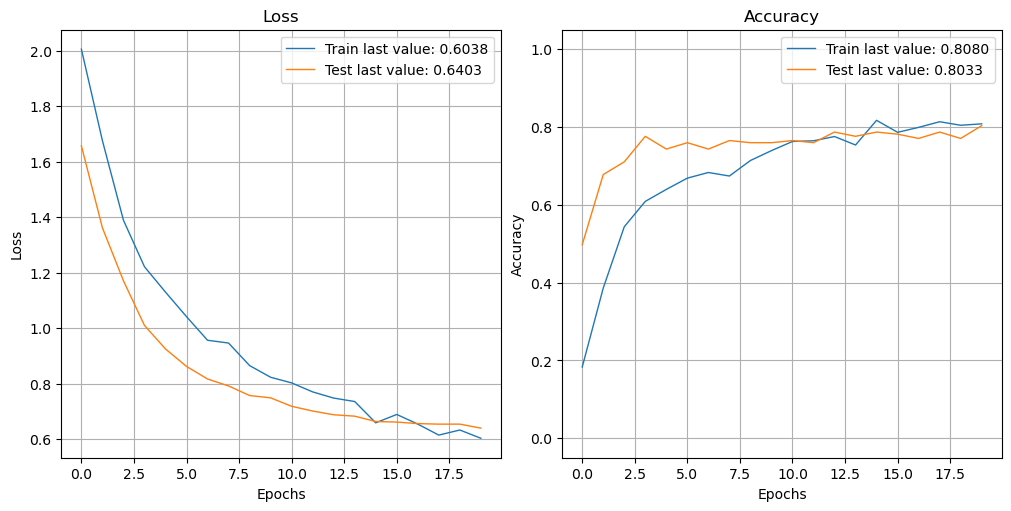

In [27]:
#on trace les historiques pour la précision et les pertes 

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [28]:
time2 = time.strftime("%H:%M:%S", time.gmtime(elapsed2))
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Essai 2',
                                          'Validation Accuracy': accuracy_val_2,
                                          'Test Accuracy':accuracy_test_2,
                                          'Validation Loss':loss_val_2,
                                          'Test Loss':loss_test_2,
                                         "Temps nécessaire pour l'entrainement du modèle":time2
                                         }, index = [0])]).reset_index(drop=True)


In [29]:
scores

,Modèle,Validation Accuracy,Test Accuracy,Validation Loss,Test Loss,Temps nécessaire pour l'entrainement du modèle
0,Essai 1,0.803279,0.777778,0.630203,0.689549,00:30:28
1,Essai 2,0.803279,0.777778,0.640290,0.702032,00:15:11


## Essai 3 :  On modifie le learning rate

In [30]:
#fonction qui crée le modele de classification

def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([RandomFlip("horizontal",input_shape=(224, 224, 3)),
                                    RandomRotation(0.1),
                                    RandomZoom(0.1),
                                    Rescaling(1./127.5,offset=-1.0)
                                   ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([data_augmentation,
                        Rescaling(1./127.5, offset=-1),
                        model_base,
                        GlobalAveragePooling2D(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(7, activation='softmax')
                       ])

    # compilation du modèle 
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", #Computes the crossentropy loss between the labels and predictions.
                  optimizer=opt,
                  metrics=["accuracy"])


    print(model.summary())
    
    return model

### Creation datasets d'entrainement, de test et de validation

In [31]:
# On utilise les images qui sont classés dans des dossiers des differents catégories de produits
batch_size = 32
path = './Flipkart/Images/df_train'
path_test = './Flipkart/Images/df_test'

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                          labels='inferred', 
                                                          label_mode='categorical',
                                                          class_names=None, 
                                                          batch_size=batch_size,
                                                          image_size=(224, 224),
                                                          shuffle=True, 
                                                          seed=42,
                                                          validation_split=validation_split, 
                                                          subset=data_type)
    return dataset

In [32]:
# on crée les datasets d'entrainement, de validation et de test
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


### Creation du modèle

In [33]:
# Création du modèle
model3 = create_model_fct2()

# Création du callback
model3_save_path = "./model7_best_weights.h5"

checkpoint = ModelCheckpoint(model3_save_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### Entrainement du modèle

In [34]:
start = time.time()
#on stocke l'historique du modèle de l'apprentissage dans une variable
history3 = model3.fit(dataset_train,
                      validation_data=dataset_val,
                      #batch_size=batch_size,      #ignored because the date is a generator
                      epochs=20, 
                      callbacks=callbacks_list, 
                      verbose=1)
end = time.time()
elapsed3 = end - start

print(f'Temps d\'exécution : {elapsed3:.2}ms')

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 2.1397 - accuracy: 0.1467
Epoch 1: val_loss improved from inf to 1.95681, saving model to ./model7_best_weights.h5
18/18 [==============================] - 46s 2s/step - loss: 2.1397 - accuracy: 0.1467 - val_loss: 1.9568 - val_accuracy: 0.1475
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 2.0384 - accuracy: 0.1413
Epoch 2: val_loss did not improve from 1.95681
18/18 [==============================] - 45s 2s/step - loss: 2.0384 - accuracy: 0.1413 - val_loss: 1.9701 - val_accuracy: 0.1257
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 2.0136 - accuracy: 0.1594
Epoch 3: val_loss improved from 1.95681 to 1.95033, saving model to ./model7_best_weights.h5
18/18 [==============================] - 44s 2s/step - loss: 2.0136 - accuracy: 0.1594 - val_loss: 1.9503 - val_accuracy: 0.1585
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 1.9756 - accuracy: 0.1558
Epoch 4:

In [35]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 34s 2s/step - loss: 1.9431 - accuracy: 0.1612
Training Accuracy   : 0.1612

6/6 [==============================] - 12s 2s/step - loss: 1.9535 - accuracy: 0.1530
Validation Accuracy :  0.1530


In [36]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss_val_3, accuracy_val_3 = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_3))

loss_test_3, accuracy_test_3 = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_3))

Validation Accuracy :  0.1202
Test Accuracy       :  0.1429


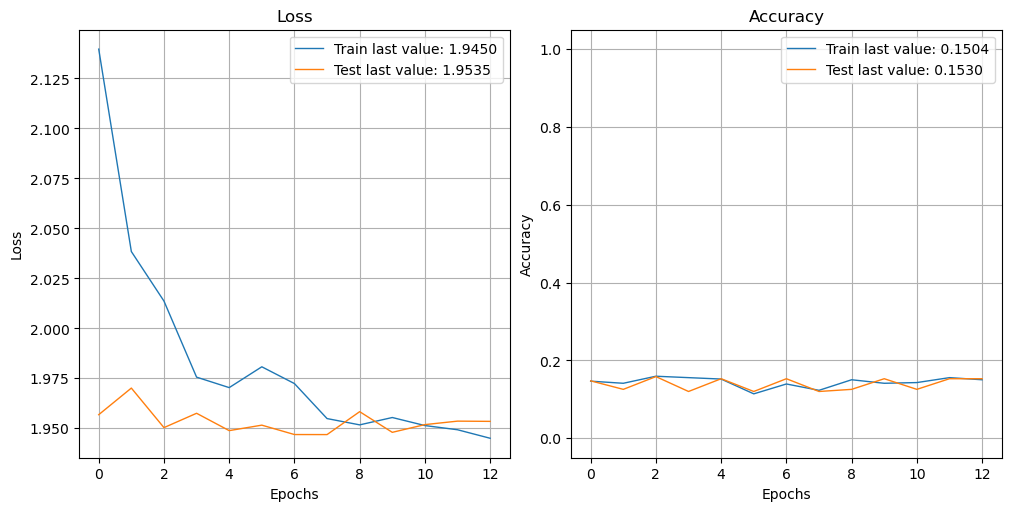

In [37]:
#on trace les historiques pour la précision et les pertes 

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [38]:
time3 = time.strftime("%H:%M:%S", time.gmtime(elapsed3))
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Essai 3',
                                          'Validation Accuracy': accuracy_val_3,
                                          'Test Accuracy':accuracy_test_3,
                                          'Validation Loss':loss_val_3,
                                          'Test Loss':loss_test_3,
                                         "Temps nécessaire pour l'entrainement du modèle":time3
                                         }, index = [0])]).reset_index(drop=True)


In [39]:
scores

,Modèle,Validation Accuracy,Test Accuracy,Validation Loss,Test Loss,Temps nécessaire pour l'entrainement du modèle
0,Essai 1,0.803279,0.777778,0.630203,0.689549,00:30:28
1,Essai 2,0.803279,0.777778,0.640290,0.702032,00:15:11
2,Essai 3,0.120219,0.142857,1.946853,1.947899,00:15:39


-> ajouter un learning rate baisse enormement le score de precision et augmente la perte

## Essai 4 : on change l'optimizer

### Creation du modèle

In [40]:
#fonction qui crée le modele de classification

def create_model_fct3() :
    # Data augmentation
    data_augmentation = Sequential([RandomFlip("horizontal",input_shape=(224, 224, 3)),
                                    RandomRotation(0.1),
                                    RandomZoom(0.1),
                                    Rescaling(1./127.5,offset=-1.0)
                                   ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    #On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([data_augmentation,
                        Rescaling(1./127.5, offset=-1),
                        model_base,
                        GlobalAveragePooling2D(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(7, activation='softmax')
                       ])

    # compilation du modèle 
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.01, clipvalue=1)
    model.compile(loss="categorical_crossentropy", #Computes the crossentropy loss between the labels and predictions.
                  optimizer=opt,
                  metrics=["accuracy"])


    print(model.summary())
    
    return model

### Creation datasets d'entrainement, de test et de validation

In [41]:
# On utilise les images qui sont classés dans des dossiers des differents catégories de produits
path = './Flipkart/Images/df_train'
path_test = './Flipkart/Images/df_test'
batch_size =32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                          labels='inferred', 
                                                          label_mode='categorical',
                                                          class_names=None, 
                                                          batch_size=batch_size,
                                                          image_size=(224, 224),
                                                          shuffle=True, 
                                                          seed=42,
                                                          validation_split=validation_split, 
                                                          subset=data_type)
    return dataset

In [42]:
# on crée les datasets d'entrainement, de validation et de test
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


### Creation du modèle

In [43]:
# Création du modèle
model4 = create_model_fct3()

# Création du callback
model4_save_path = "./model8_best_weights.h5"

checkpoint = ModelCheckpoint(model4_save_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   verbose=1, 
                   patience=5)

callbacks_list = [checkpoint, es]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

### Entrainement du modèle

In [44]:
start = time.time()
#on stocke l'historique du modèle de l'apprentissage dans une variable
history4 = model4.fit(dataset_train,
                      validation_data=dataset_val,
                      #batch_size=batch_size,      #ignored because the date is a generator
                      epochs=20, 
                      callbacks=callbacks_list, 
                      verbose=1)
end = time.time()
elapsed4 = end - start

print(f'Temps d\'exécution : {elapsed4:.2}ms')

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 2.0973 - accuracy: 0.1467
Epoch 1: val_loss improved from inf to 1.96479, saving model to ./model8_best_weights.h5
18/18 [==============================] - 48s 3s/step - loss: 2.0973 - accuracy: 0.1467 - val_loss: 1.9648 - val_accuracy: 0.1475
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 2.0602 - accuracy: 0.1540
Epoch 2: val_loss did not improve from 1.96479
18/18 [==============================] - 46s 3s/step - loss: 2.0602 - accuracy: 0.1540 - val_loss: 1.9828 - val_accuracy: 0.1475
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 2.0101 - accuracy: 0.1576
Epoch 3: val_loss improved from 1.96479 to 1.96152, saving model to ./model8_best_weights.h5
18/18 [==============================] - 46s 3s/step - loss: 2.0101 - accuracy: 0.1576 - val_loss: 1.9615 - val_accuracy: 0.1530
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 2.0168 - accuracy: 0.1413
Epoch 4:

In [45]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 34s 2s/step - loss: 1.9463 - accuracy: 0.1612
Training Accuracy   : 0.1612

6/6 [==============================] - 11s 2s/step - loss: 1.9559 - accuracy: 0.1530
Validation Accuracy :  0.1530


In [46]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss_val_4, accuracy_val_4 = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_4))

loss_test_4, accuracy_test_4 = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_4))

Validation Accuracy :  0.1202
Test Accuracy       :  0.1429


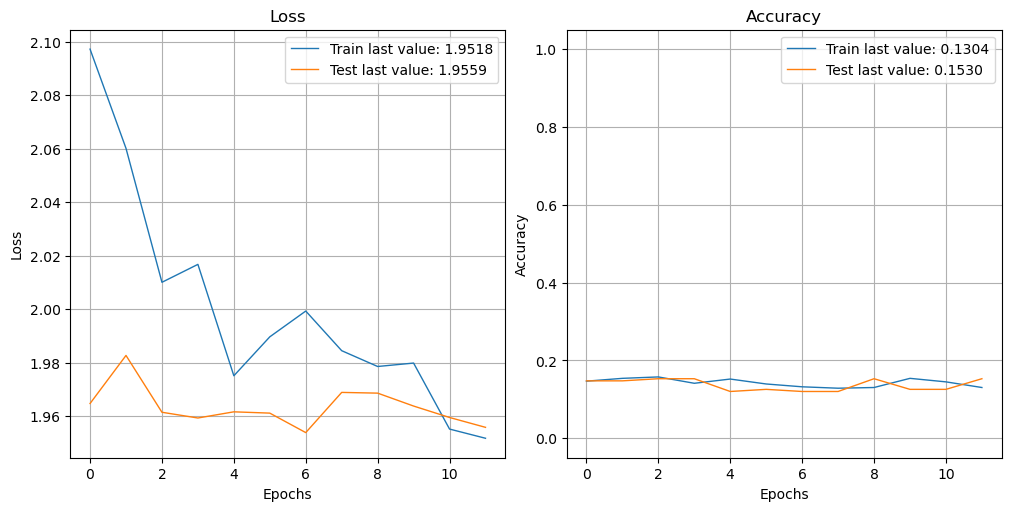

In [47]:
#on trace les historiques pour la précision et les pertes 

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [48]:
time4 = time.strftime("%H:%M:%S", time.gmtime(elapsed4))
scores = pd.concat([scores, pd.DataFrame({'Modèle':'Essai 4',
                                          'Validation Accuracy': accuracy_val_4,
                                          'Test Accuracy':accuracy_test_4,
                                          'Validation Loss':loss_val_4,
                                          'Test Loss':loss_test_4,
                                         "Temps nécessaire pour l'entrainement du modèle":time4
                                         }, index = [0])]).reset_index(drop=True)


In [49]:
scores

,Modèle,Validation Accuracy,Test Accuracy,Validation Loss,Test Loss,Temps nécessaire pour l'entrainement du modèle
0,Essai 1,0.803279,0.777778,0.630203,0.689549,00:30:28
1,Essai 2,0.803279,0.777778,0.640290,0.702032,00:15:11
2,Essai 3,0.120219,0.142857,1.946853,1.947899,00:15:39
3,Essai 4,0.120219,0.142857,1.953915,1.946819,00:09:12
